# Rede CNN - MFCC

**Experimentos preliminares**

## Importação

In [1]:
from util import *
from models import *
from activations import *

1 Physical GPUs, 1 Logical GPUs


## Definições

In [2]:
POS_CLASS       = 'DISFARCE'
GROUP_TRAIN     = 'GG,GH,GM,GR'
GROUP_TEST      = 'GC'
DATASET         = 'dataset_2_processed'
DURATION        = 8
SIZE            = 345
CSV_TRAIN       = f'{DATASET}/train.csv'
CSV_TEST        = f'{DATASET}/test.csv'

BALANCE_DATA    = False
SHUFFLE         = True
AUGMENT         = 'default' if 'aug' in DATASET else None
COMMENTS        = ''
N_MELS          = 40

SHAPE           = (N_MELS, SIZE, 1)

In [3]:
EPOCHS = 1000
LR = 0.0001
LOSSF = 'binary_crossentropy'
BATCH_SIZE = 36

NOW = datetime.now().strftime("%Y%m%d_%H%M%S")
TOPOLOGY = 'CNN_MFCC2'
MODEL_NAME = f'{DATASET}__{NOW}__{DURATION}__{EPOCHS}__LR{LR}__AUG_{AUGMENT}__BAL_{BALANCE_DATA}__BS{BATCH_SIZE}'

### Metadados

In [4]:
train_data = pd.read_csv(CSV_TRAIN) # patient diagnosis file
test_data = pd.read_csv(CSV_TEST) # patient diagnosis file

if SHUFFLE:
    train_data = train_data.sample(frac=1)
print("Train data:", len(train_data))
print("Test data:", len(test_data))

Train data: 551
Test data: 135


In [5]:
train_labels = np.array(train_data['classe']) 
train_file_paths = np.array(train_data['path'])
test_labels = np.array(test_data['classe']) 
test_file_paths = np.array(test_data['path'])

In [6]:
train_features = [] 
test_features = []

for file_name in train_file_paths:
    data = extract_features(file_name, duration=DURATION)
    train_features.append(data)

for file_name in test_file_paths:
    data = extract_features(file_name, duration=DURATION)
    test_features.append(data)

print('Finished feature extraction from ', (len(train_features)+len(test_features)), ' files')
train_features = np.array(train_features)
test_features = np.array(test_features)

Finished feature extraction from  686  files


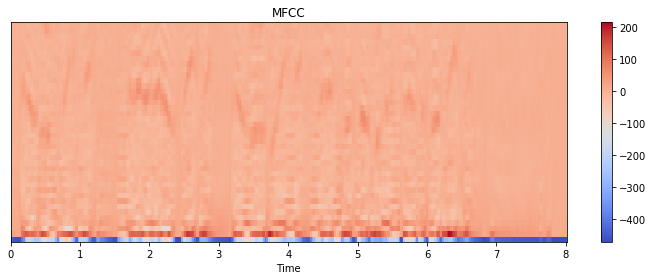

In [7]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [8]:
np.unique(train_labels)

array(['DISFARCE', 'NORMAL'], dtype=object)

In [9]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements_test, counts_elements_test = np.unique(test_labels, return_counts=True)
print(np.asarray((unique_elements_test, counts_elements_test)))

[['DISFARCE' 'NORMAL']
 [262 289]]
[['DISFARCE' 'NORMAL']
 [70 65]]


__Balanceando dados__

In [10]:
if BALANCE_DATA:
    train_features, train_labels = balance_data(train_features, train_labels)
    test_features, test_labels = balance_data(test_features, test_labels)

In [11]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements_test, counts_elements_test = np.unique(test_labels, return_counts=True)
print(np.asarray((unique_elements_test, counts_elements_test)))

[['DISFARCE' 'NORMAL']
 [262 289]]
[['DISFARCE' 'NORMAL']
 [70 65]]


In [12]:
# One-hot encode labels
# le = LabelEncoder()
# le.fit(train_labels)
train_labels_cat = np.array([1 if y==POS_CLASS else 0 for y in train_labels])
# train_labels_cat = le.transform(train_labels)
test_labels_cat = np.array([1 if y==POS_CLASS else 0 for y in test_labels])
# test_labels_cat = le.transform(test_labels) 

In [13]:
train_features.shape

(551, 40, 345)

In [14]:
train_features = np.reshape(train_features, (*train_features.shape,1)) 
print(train_features.shape, train_labels_cat.shape)
test_features = np.reshape(test_features, (*test_features.shape,1)) 
print(test_features.shape, test_labels_cat.shape)

(551, 40, 345, 1) (551,)
(135, 40, 345, 1) (135,)


In [15]:
x_test, y_test = test_features, test_labels_cat
x_train, y_train = train_features, train_labels_cat

## Modelos

**Veja models.py**

In [16]:
model = globals()[TOPOLOGY](SHAPE)

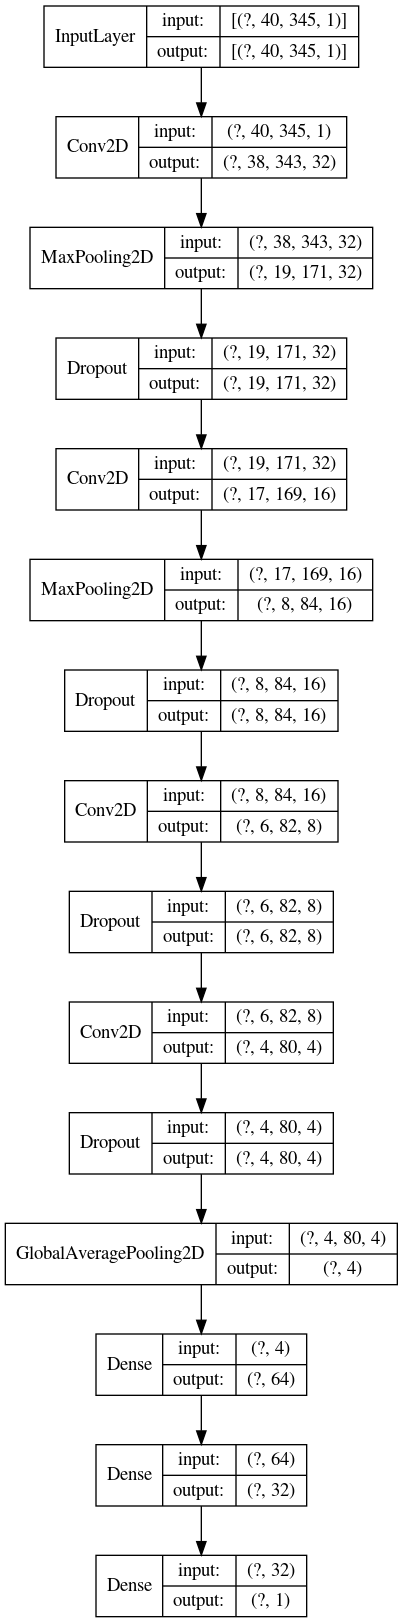

In [17]:
os.makedirs('topologias', exist_ok=True)
plot_model(model, to_file=f'topologias{os.sep}{TOPOLOGY}.png',
           show_shapes=True, show_layer_names=False)

### Otimizador

In [18]:
opt = tf.keras.optimizers.Adam(LR)

### Compile

In [19]:
# Compile the model
model.compile(loss=LOSSF, metrics=['accuracy'], optimizer=opt) 

In [20]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

5/5 [==============================] - 0s 8ms/step - loss: 1.1087 - accuracy: 0.5185
Pre-training accuracy: 51.8519%


## Treinamento

In [21]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=50, 
                                            verbose=0, 
                                            factor=0.9, 
                                            min_lr=0.0001)

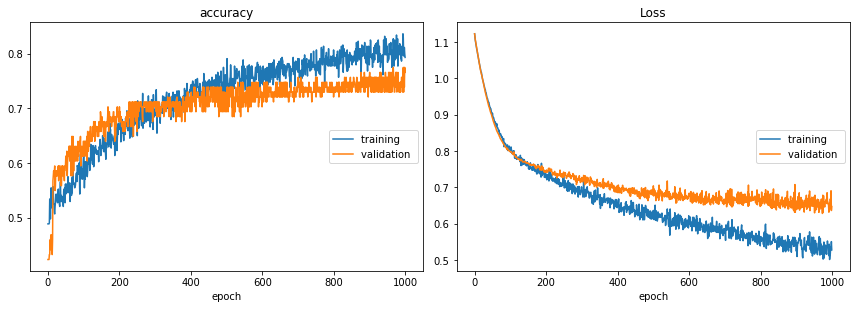

accuracy
	training         	 (min:    0.489, max:    0.836, cur:    0.793)
	validation       	 (min:    0.423, max:    0.775, cur:    0.766)
Loss
	training         	 (min:    0.501, max:    1.123, cur:    0.528)
	validation       	 (min:    0.628, max:    1.123, cur:    0.647)
13/13 [==============================] - 0s 23ms/step - loss: 0.5278 - accuracy: 0.7932 - val_loss: 0.6473 - val_accuracy: 0.7658 - lr: 1.0000e-04
Training completed in time:  0:05:10.143162


In [22]:
checkpoint_filepath = f'models/{MODEL_NAME}.h5'

os.makedirs('models', exist_ok=True)
callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    PlotLossesKeras(),
    learning_rate_reduction
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=.2, callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

**Plot accuracies and losses**

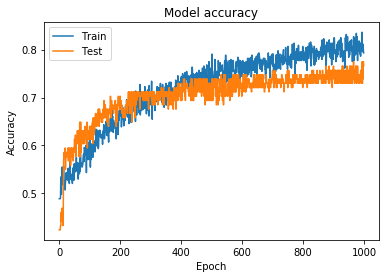

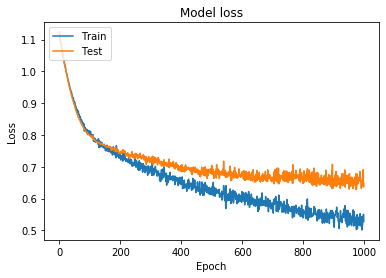

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Teste

In [24]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
train_acc = score[1]
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
test_acc = score[1]
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8021778464317322
Testing Accuracy:  0.770370364189148


In [25]:
preds = model.predict(x_test) # label scores 
print(preds[:5])
print(preds[-5:])
scr = .5

classpreds = np.array([1 if y > scr else 0 for y in preds])# predicted classes 

y_testclass =  np.array([1 if y > scr else 0 for y in y_test]) # true classes

n_classes=2 # number of classes

[[0.6101901 ]
 [0.96099085]
 [0.72677886]
 [0.8890533 ]
 [0.9866154 ]]
[[0.69916993]
 [0.15326071]
 [0.14111969]
 [0.30501515]
 [0.17593211]]


In [26]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[56  9]
 [22 48]]


In [27]:
c_names = ["NORMAL", "DISFARCE"]

In [28]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

              precision    recall  f1-score   support

      NORMAL       0.72      0.86      0.78        65
    DISFARCE       0.84      0.69      0.76        70

    accuracy                           0.77       135
   macro avg       0.78      0.77      0.77       135
weighted avg       0.78      0.77      0.77       135



## Teste do melhor modelo

In [29]:
print(checkpoint_filepath)

models/dataset_2_processed__20201102_115951__8__1000__LR0.0001__AUG_None__BAL_False__BS36.h5


In [30]:
model = load_model(checkpoint_filepath)

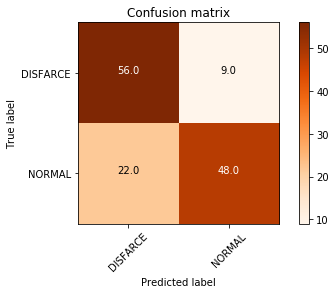

In [31]:
plot_confusion_matrix(confusion_matrix(y_testclass, classpreds),
                      unique_labels=["DISFARCE", "NORMAL"])

__Write CSV__

In [32]:
with open('report.csv', 'a') as report:
    report.write(f'{MODEL_NAME},{TOPOLOGY},{DATASET},{DURATION},{train_acc},{test_acc},{COMMENTS}\n')